In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [53]:
df_seq = pd.read_csv('smi.csv', header=None)

In [54]:
df_seq.head()

,0
0,smiles
1,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@...
2,CCNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N)=N)NC(=...
3,CC(C)C[C@H](NC(=O)[C@@H](COC(C)(C)C)NC(=O)[C@H...
4,NC(=O)CC[C@@H]1NC(=O)[C@H](CC2=CC=CC=C2)NC(=O)...


In [55]:
len(df_seq)

8289

In [57]:
df_seq[0].values[1]

'CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CC(O)=O)NC(=O)CNC(=O)[C@H](CC(N)=O)NC(=O)CNC(=O)CNC(=O)CNC(=O)CNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N)=N)NC(=O)[C@@H]1CCCN1C(=O)[C@H](N)CC1=CC=CC=C1)C(=O)N1CCC[C@H]1C(=O)N[C@@H](CCC(O)=O)C(=O)N[C@@H](CCC(O)=O)C(=O)N[C@@H](CC1=CC=C(O)C=C1)C(=O)N[C@@H](CC(C)C)C(O)=O'

In [58]:
freq_codes = []

In [59]:
import os
import sys
import inspect
import codecs
import re
import copy
import argparse
import warnings
from collections import defaultdict, Counter


In [60]:
def get_vocabulary(fobj, is_dict=False):
#     Read text and return dictionary that encodes vocabulary
    vocab = Counter()
    for i, line in enumerate(fobj):
        if is_dict:
            try:
                word, count = line.strip('\r\n ').split(' ')
            except:
                print('Failed reading vocabulary file at line {0}: {1}'.format(i, line))
                sys.exit(1)
            vocab[word] += int(count)
        else:
            for word in line.strip('\r\n ').split(' '):
                if word:
                    vocab[word] += 1
        
    
    vocab = Counter()
    for word in fobj:
        vocab[word] += 1
    return vocab

In [61]:
def update_pair_statistics(pair, changed, stats, indices):
    """Minimally update the indices and frequency of symbol pairs
    if we merge a pair of symbols, only pairs that overlap with occurrences
    of this pair are affected, and need to be updated.
    """
    stats[pair] = 0
    indices[pair] = defaultdict(int)
    first, second = pair
    new_pair = first+second
    for j, word, old_word, freq in changed:

        # find all instances of pair, and update frequency/indices around it
        i = 0
        while True:
            # find first symbol
            try:
                i = old_word.index(first, i)
            except ValueError:
                break
            # if first symbol is followed by second symbol, we've found an occurrence of pair (old_word[i:i+2])
            if i < len(old_word)-1 and old_word[i+1] == second:
                # assuming a symbol sequence "A B C", if "B C" is merged, reduce the frequency of "A B"
                if i:
                    prev = old_word[i-1:i+1]
                    stats[prev] -= freq
                    indices[prev][j] -= 1
                if i < len(old_word)-2:
                    # assuming a symbol sequence "A B C B", if "B C" is merged, reduce the frequency of "C B".
                    # however, skip this if the sequence is A B C B C, because the frequency of "C B" will be reduced by the previous code block
                    if old_word[i+2] != first or i >= len(old_word)-3 or old_word[i+3] != second:
                        nex = old_word[i+1:i+3]
                        stats[nex] -= freq
                        indices[nex][j] -= 1
                i += 2
            else:
                i += 1

        i = 0
        while True:
            try:
                # find new pair
                i = word.index(new_pair, i)
            except ValueError:
                break
            # assuming a symbol sequence "A BC D", if "B C" is merged, increase the frequency of "A BC"
            if i:
                prev = word[i-1:i+1]
                stats[prev] += freq
                indices[prev][j] += 1
            # assuming a symbol sequence "A BC B", if "B C" is merged, increase the frequency of "BC B"
            # however, if the sequence is A BC BC, skip this step because the count of "BC BC" will be incremented by the previous code block
            if i < len(word)-1 and word[i+1] != new_pair:
                nex = word[i:i+2]
                stats[nex] += freq
                indices[nex][j] += 1
            i += 1


In [62]:
def get_pair_statistics(vocab):
    """Count frequency of all symbol pairs, and create index"""

    # data structure of pair frequencies
    stats = defaultdict(int)

    #index from pairs to words
    indices = defaultdict(lambda: defaultdict(int))

    for i, (word, freq) in enumerate(vocab):
        prev_char = word[0]
        for char in word[1:]:
            stats[prev_char, char] += freq
            indices[prev_char, char][i] += 1
            prev_char = char

    return stats, indices


def replace_pair(pair, vocab, indices):
    """Replace all occurrences of a symbol pair ('A', 'B') with a new symbol 'AB'"""
    first, second = pair
    pair_str = ''.join(pair)
    pair_str = pair_str.replace('\\','\\\\')
    changes = []
    pattern = re.compile(r'(?<!\S)' + re.escape(first + ' ' + second) + r'(?!\S)')
    if sys.version_info < (3, 0):
        iterator = indices[pair].iteritems()
    else:
        iterator = indices[pair].items()
    for j, freq in iterator:
        if freq < 1:
            continue
        word, freq = vocab[j]
        new_word = ' '.join(word)
        new_word = pattern.sub(pair_str, new_word)
        new_word = tuple(new_word.split(' '))

        vocab[j] = (new_word, freq)
        changes.append((j, new_word, word, freq))

    return changes

def prune_stats(stats, big_stats, threshold):
    """Prune statistics dict for efficiency of max()
    The frequency of a symbol pair never increases, so pruning is generally safe
    (until we the most frequent pair is less frequent than a pair we previously pruned)
    big_stats keeps full statistics for when we need to access pruned items
    """
    for item,freq in list(stats.items()):
        if freq < threshold:
            del stats[item]
            if freq < 0:
                big_stats[item] += freq
            else:
                big_stats[item] = freq


def learn_bpe(infile, outfile, num_symbols, min_frequency=2, verbose=False, is_dict=False, total_symbols=False):
    """Learn num_symbols BPE operations from vocabulary, and write to outfile.
    """

    # version 0.2 changes the handling of the end-of-word token ('</w>');
    # version numbering allows bckward compatibility
    outfile.write('#version: 0.2\n')

    vocab = get_vocabulary(infile, is_dict)
    vocab = dict([(tuple(x[:-1])+(x[-1]+'</w>',) ,y) for (x,y) in vocab.items()])
    sorted_vocab = sorted(vocab.items(), key=lambda x: x[1], reverse=True)

    stats, indices = get_pair_statistics(sorted_vocab)
    big_stats = copy.deepcopy(stats)

    if total_symbols:
        uniq_char_internal = set()
        uniq_char_final = set()
        for word in vocab:
            for char in word[:-1]:
                uniq_char_internal.add(char)
            uniq_char_final.add(word[-1])
        sys.stderr.write('Number of word-internal characters: {0}\n'.format(len(uniq_char_internal)))
        sys.stderr.write('Number of word-final characters: {0}\n'.format(len(uniq_char_final)))
        sys.stderr.write('Reducing number of merge operations by {0}\n'.format(len(uniq_char_internal) + len(uniq_char_final)))
        num_symbols -= len(uniq_char_internal) + len(uniq_char_final)
        for i in uniq_char_internal:
            vocab_index2units2freq[i] = 0

    # threshold is inspired by Zipfian assumption, but should only affect speed
    threshold = max(stats.values()) / 10
    for i in range(num_symbols):
        if stats:
            most_frequent = max(stats, key=lambda x: (stats[x], x))

        # we probably missed the best pair because of pruning; go back to full statistics
        if not stats or (i and stats[most_frequent] < threshold):
            prune_stats(stats, big_stats, threshold)
            stats = copy.deepcopy(big_stats)
            most_frequent = max(stats, key=lambda x: (stats[x], x))
            # threshold is inspired by Zipfian assumption, but should only affect speed
            threshold = stats[most_frequent] * i/(i+10000.0)
            prune_stats(stats, big_stats, threshold)

        if stats[most_frequent] < min_frequency:
            sys.stderr.write('no pair has frequency >= {0}. Stopping\n'.format(min_frequency))
            break
        
        #essential
        s1 = most_frequent[0].replace('</w>','')
        s2 = most_frequent[1].replace('</w>','')
        
        vocab_index2units2freq[s1+s2] = stats[most_frequent]
        
        if verbose:
            sys.stderr.write('pair {0}: {1} {2} -> {1}{2} (frequency {3})\n'.format(i, most_frequent[0], most_frequent[1], stats[most_frequent]))
        outfile.write('{0} {1}\n'.format(*most_frequent))
        freq_codes.append(most_frequent)
        changes = replace_pair(most_frequent, sorted_vocab, indices)
        update_pair_statistics(most_frequent, changes, stats, indices)
        stats[most_frequent] = 0
        if not i % 100:
            prune_stats(stats, big_stats, threshold)

In [79]:
vocab_index2units2freq = {}
seq = (df_seq[0].values)
output = open('drug_codes_drug_bank_freq_100.txt', 'w+')
learn_bpe(seq, output, 30000, min_frequency=10, verbose=True, is_dict=False, total_symbols=True)

Number of word-internal characters: 54
Number of word-final characters: 15
Reducing number of merge operations by 69
pair 0: = C -> =C (frequency 35095)
pair 1: O ) -> O) (frequency 24715)
pair 2: C C -> CC (frequency 22096)
pair 3: [ C -> [C (frequency 18298)
pair 4: [C @ -> [C@ (frequency 18243)
pair 5: C ( -> C( (frequency 17635)
pair 6: H ] -> H] (frequency 17560)
pair 7: C =C -> C=C (frequency 15971)
pair 8: = O) -> =O) (frequency 13470)
pair 9: [C@ @ -> [C@@ (frequency 8814)
pair 10: C ) -> C) (frequency 8323)
pair 11: C 1 -> C1 (frequency 7783)
pair 12: C( =O) -> C(=O) (frequency 7721)
pair 13: H] ( -> H]( (frequency 7369)
pair 14: [ H] -> [H] (frequency 6646)
pair 15: =C C=C -> =CC=C (frequency 6103)
pair 16: ( O) -> (O) (frequency 4611)
pair 17: [H] ) -> [H]) (frequency 4369)
pair 18: C 2 -> C2 (frequency 4363)
pair 19: ( [H]) -> ([H]) (frequency 4110)
pair 20: 1 ) -> 1) (frequency 3996)
pair 21: [C@ H]( -> [C@H]( (frequency 3968)
pair 22: = N -> =N (frequency 3946)
pair 23: =

pair 200: I ) -> I) (frequency 197)
pair 201: N 1) -> N1) (frequency 195)
pair 202: C=C 3 -> C=C3 (frequency 195)
pair 203: ( CO -> (CO (frequency 192)
pair 204: P(O)(=O) O -> P(O)(=O)O (frequency 191)
pair 205: CC CN -> CCCN (frequency 190)
pair 206: [C@@ H]3 -> [C@@H]3 (frequency 187)
pair 207: N (C) -> N(C) (frequency 185)
pair 208: O 1) -> O1) (frequency 184)
pair 209: CC1 =C( -> CC1=C( (frequency 183)
pair 210: C2=CC=C C=C2 -> C2=CC=CC=C2 (frequency 180)
pair 211: CC1=CC=C C=C1) -> CC1=CC=CC=C1) (frequency 178)
pair 212: C2 ) -> C2) (frequency 176)
pair 213: C(=O) CC -> C(=O)CC (frequency 175)
pair 214: =C 2 -> =C2 (frequency 175)
pair 215: =CC=C 1 -> =CC=C1 (frequency 174)
pair 216: NC(=O) [C@@H]( -> NC(=O)[C@@H]( (frequency 173)
pair 217: C(F)(F) F) -> C(F)(F)F) (frequency 170)
pair 218: C=C C=C -> C=CC=C (frequency 169)
pair 219: C [C@@H]( -> C[C@@H]( (frequency 168)
pair 220: CC2 =CC=C -> CC2=CC=C (frequency 167)
pair 221: C(=O)N CC -> C(=O)NCC (frequency 165)
pair 222: [H][C@

pair 379: C2=CC=CC=C1 2) -> C2=CC=CC=C12) (frequency 81)
pair 380: C2=C( C=C -> C2=C(C=C (frequency 81)
pair 381: [C@@H]1 O) -> [C@@H]1O) (frequency 80)
pair 382: [C@@H]1 CC -> [C@@H]1CC (frequency 80)
pair 383: S (C) -> S(C) (frequency 80)
pair 384: [C@@]2 1 -> [C@@]21 (frequency 79)
pair 385: O[C@H](CO) [C@@H](O)[C@H](O) -> O[C@H](CO)[C@@H](O)[C@H](O) (frequency 79)
pair 386: O[C@H]( [C@H](O) -> O[C@H]([C@H](O) (frequency 79)
pair 387: CN 2 -> CN2 (frequency 79)
pair 388: C1=C C(=C -> C1=CC(=C (frequency 79)
pair 389: N C2=N -> NC2=N (frequency 78)
pair 390: C( = -> C(= (frequency 78)
pair 391: [N H -> [NH (frequency 77)
pair 392: [C@@]1([H]) [C@@]2([H])CC -> [C@@]1([H])[C@@]2([H])CC (frequency 77)
pair 393: S(O) (=O)=O) -> S(O)(=O)=O) (frequency 77)
pair 394: =C( C) -> =C(C) (frequency 77)
pair 395: ] . -> ]. (frequency 76)
pair 396: [C@@ H]4 -> [C@@H]4 (frequency 76)
pair 397: C(Cl) =C -> C(Cl)=C (frequency 76)
pair 398: C(C) C</w> -> C(C)C</w> (frequency 76)
pair 399: C(=N ) -> C(

pair 554: (CC (C)C) -> (CC(C)C) (frequency 51)
pair 555: a +]. -> a+]. (frequency 50)
pair 556: [N a+]. -> [Na+]. (frequency 50)
pair 557: [H][C@]1 (CC -> [H][C@]1(CC (frequency 50)
pair 558: S(N) (=O)=O</w> -> S(N)(=O)=O</w> (frequency 50)
pair 559: CC N1 -> CCN1 (frequency 50)
pair 560: C=C ) -> C=C) (frequency 50)
pair 561: C(N) = -> C(N)= (frequency 50)
pair 562: (C # -> (C# (frequency 50)
pair 563: [H][C@]1 (CO) -> [H][C@]1(CO) (frequency 49)
pair 564: [C@] (C) -> [C@](C) (frequency 49)
pair 565: [C@@H]2 O) -> [C@@H]2O) (frequency 49)
pair 566: S(C) (=O)=O) -> S(C)(=O)=O) (frequency 49)
pair 567: NC(=O)[C@H]( CC -> NC(=O)[C@H](CC (frequency 49)
pair 568: C4=C 3 -> C4=C3 (frequency 49)
pair 569: C1=N N -> C1=NN (frequency 49)
pair 570: C(=N 2) -> C(=N2) (frequency 49)
pair 571: =C 4 -> =C4 (frequency 49)
pair 572: CC 3) -> CC3) (frequency 48)
pair 573: C1=CC=C C(=C1) -> C1=CC=CC(=C1) (frequency 48)
pair 574: C1=C2 C=C -> C1=C2C=C (frequency 48)
pair 575: C(O)=C 2 -> C(O)=C2 (freque

pair 748: [ 1 -> [1 (frequency 34)
pair 749: S(N) (=O)=O) -> S(N)(=O)=O) (frequency 34)
pair 750: CC[C@@]21 [H]</w> -> CC[C@@]21[H]</w> (frequency 34)
pair 751: CC(C) C[C@H]( -> CC(C)C[C@H]( (frequency 34)
pair 752: C=C( O -> C=C(O (frequency 34)
pair 753: C=C 4) -> C=C4) (frequency 34)
pair 754: C1=CC2=C( N -> C1=CC2=C(N (frequency 34)
pair 755: C1=C( N -> C1=C(N (frequency 34)
pair 756: C(N)= N</w> -> C(N)=N</w> (frequency 34)
pair 757: C(C)(C) [C@@H]( -> C(C)(C)[C@@H]( (frequency 34)
pair 758: C(=O)N [C@H]1 -> C(=O)N[C@H]1 (frequency 34)
pair 759: B r</w> -> Br</w> (frequency 34)
pair 760: 2 =C -> 2=C (frequency 34)
pair 761: [H][C@@]1 (C -> [H][C@@]1(C (frequency 33)
pair 762: [C@H]( CO) -> [C@H](CO) (frequency 33)
pair 763: [C@@]1(C)C[C@H](O) [C@@]1 -> [C@@]1(C)C[C@H](O)[C@@]1 (frequency 33)
pair 764: [C@@H](O P(O)(O)=O) -> [C@@H](OP(O)(O)=O) (frequency 33)
pair 765: [C@@H](C) O) -> [C@@H](C)O) (frequency 33)
pair 766: O [C@@H](O -> O[C@@H](O (frequency 33)
pair 767: O 3) -> O3) (

pair 944: CCCN 2 -> CCCN2 (frequency 25)
pair 945: CC1=CC=C C=C1 -> CC1=CC=CC=C1 (frequency 25)
pair 946: CC C1 -> CCC1 (frequency 25)
pair 947: C=C C4=C3 -> C=CC4=C3 (frequency 25)
pair 948: C2=C1 N -> C2=C1N (frequency 25)
pair 949: C2=C( N -> C2=C(N (frequency 25)
pair 950: C2=C N -> C2=CN (frequency 25)
pair 951: C2 CC2) -> C2CC2) (frequency 25)
pair 952: C(\ C) -> C(\C) (frequency 25)
pair 953: C(O)=C 2) -> C(O)=C2) (frequency 25)
pair 954: C(F) =C1</w> -> C(F)=C1</w> (frequency 25)
pair 955: C(=O)N([H]) CC -> C(=O)N([H])CC (frequency 25)
pair 956: C(=O)N C2=O) -> C(=O)NC2=O) (frequency 25)
pair 957: C(=O)C=C3 CC[C@@]21[H]</w> -> C(=O)C=C3CC[C@@]21[H]</w> (frequency 25)
pair 958: C( CO -> C(CO (frequency 25)
pair 959: C =[N+] -> C=[N+] (frequency 25)
pair 960: =CC=C 3 -> =CC=C3 (frequency 25)
pair 961: =C( O -> =C(O (frequency 25)
pair 962: =C( C=C1) -> =C(C=C1) (frequency 25)
pair 963: ( C=C2) -> (C=C2) (frequency 25)
pair 964: [C@]2 (O) -> [C@]2(O) (frequency 24)
pair 965: [C@H]

pair 1169: CN1 C=C( -> CN1C=C( (frequency 19)
pair 1170: CN S(=O)(=O) -> CNS(=O)(=O) (frequency 19)
pair 1171: CCCCCCCC ) -> CCCCCCCC) (frequency 19)
pair 1172: CCCC (O)=O) -> CCCC(O)=O) (frequency 19)
pair 1173: CC1=C( F) -> CC1=C(F) (frequency 19)
pair 1174: CC(=O) O -> CC(=O)O (frequency 19)
pair 1175: CC(=O) N1 -> CC(=O)N1 (frequency 19)
pair 1176: CC C1=C( -> CCC1=C( (frequency 19)
pair 1177: C=N N2 -> C=NN2 (frequency 19)
pair 1178: C=C2) =N -> C=C2)=N (frequency 19)
pair 1179: C2=CC=C(Cl) C=C2) -> C2=CC=C(Cl)C=C2) (frequency 19)
pair 1180: C2 CCCC2) -> C2CCCC2) (frequency 19)
pair 1181: C1=CC=C( NC(=O) -> C1=CC=C(NC(=O) (frequency 19)
pair 1182: C1=CC=C C=N1</w> -> C1=CC=CC=N1</w> (frequency 19)
pair 1183: C1 CC1) -> C1CC1) (frequency 19)
pair 1184: C(O)=C 3 -> C(O)=C3 (frequency 19)
pair 1185: C(N C2=CC=C(C=C2) -> C(NC2=CC=C(C=C2) (frequency 19)
pair 1186: C(Cl) =C1 -> C(Cl)=C1 (frequency 19)
pair 1187: C(C)=C 2 -> C(C)=C2 (frequency 19)
pair 1188: C(=O)N1 CC -> C(=O)N1CC (freq

pair 1393: =C(C) C) -> =C(C)C) (frequency 16)
pair 1394: =C( I)C( -> =C(I)C( (frequency 16)
pair 1395: =C ([H]) -> =C([H]) (frequency 16)
pair 1396: (Cl) C=C2) -> (Cl)C=C2) (frequency 16)
pair 1397: (CC 1) -> (CC1) (frequency 16)
pair 1398: n ++]. -> n++]. (frequency 15)
pair 1399: \C=C1 / -> \C=C1/ (frequency 15)
pair 1400: \ C1=CSC(N)=N1) -> \C1=CSC(N)=N1) (frequency 15)
pair 1401: \ C(=N/ -> \C(=N/ (frequency 15)
pair 1402: [OH -]. -> [OH-]. (frequency 15)
pair 1403: [O- -]. -> [O--]. (frequency 15)
pair 1404: [NH3 +]) -> [NH3+]) (frequency 15)
pair 1405: [M g -> [Mg (frequency 15)
pair 1406: [H][C@]1 (O -> [H][C@]1(O (frequency 15)
pair 1407: [H][C@@]12CC[C@@](O) (C#C) -> [H][C@@]12CC[C@@](O)(C#C) (frequency 15)
pair 1408: [H][C@@]12CC [C@H]( -> [H][C@@]12CC[C@H]( (frequency 15)
pair 1409: [H][C@@]12C [C@@]3([H]) -> [H][C@@]12C[C@@]3([H]) (frequency 15)
pair 1410: [H][C@@]1 (C) -> [H][C@@]1(C) (frequency 15)
pair 1411: [Ca ++]. -> [Ca++]. (frequency 15)
pair 1412: [C@]([H])(O) [C@@

pair 1581: N C(=O)N1 -> NC(=O)N1 (frequency 13)
pair 1582: C[C@@] (O) -> C[C@@](O) (frequency 13)
pair 1583: CS CC -> CSCC (frequency 13)
pair 1584: COC1=CC(=CC(OC)=C1 OC) -> COC1=CC(=CC(OC)=C1OC) (frequency 13)
pair 1585: CO C) -> COC) (frequency 13)
pair 1586: CN1 CC -> CN1CC (frequency 13)
pair 1587: CN1 C2=CC=CC=C2 -> CN1C2=CC=CC=C2 (frequency 13)
pair 1588: CN1 C(=O)[C@@H]( -> CN1C(=O)[C@@H]( (frequency 13)
pair 1589: CN(CC (O)=O) -> CN(CC(O)=O) (frequency 13)
pair 1590: CN(C) C(=O) -> CN(C)C(=O) (frequency 13)
pair 1591: CN =C( -> CN=C( (frequency 13)
pair 1592: CN 1) -> CN1) (frequency 13)
pair 1593: CCN(CC ([O-])=O) -> CCN(CC([O-])=O) (frequency 13)
pair 1594: CCCC CC) -> CCCCCC) (frequency 13)
pair 1595: CCC [C@@H](C) -> CCC[C@@H](C) (frequency 13)
pair 1596: CC1=CC=C S1) -> CC1=CC=CS1) (frequency 13)
pair 1597: CC1=C( Cl) -> CC1=C(Cl) (frequency 13)
pair 1598: CC1) C1=CC=CC=C1</w> -> CC1)C1=CC=CC=C1</w> (frequency 13)
pair 1599: CC(O)=O) C(O)=O</w> -> CC(O)=O)C(O)=O</w> (freq

pair 1800: N (O) -> N(O) (frequency 11)
pair 1801: C[N+] # -> C[N+]# (frequency 11)
pair 1802: C[C@]12CC [C@H]3 -> C[C@]12CC[C@H]3 (frequency 11)
pair 1803: C[C@H]( N -> C[C@H](N (frequency 11)
pair 1804: COC1=CC=C C2=C1 -> COC1=CC=CC2=C1 (frequency 11)
pair 1805: COC1=C(OC) C=C2 -> COC1=C(OC)C=C2 (frequency 11)
pair 1806: CO C(C)(C) -> COC(C)(C) (frequency 11)
pair 1807: CN(CC N(CC -> CN(CCN(CC (frequency 11)
pair 1808: CN( C(=O) -> CN(C(=O) (frequency 11)
pair 1809: CN CC -> CNCC (frequency 11)
pair 1810: CN ([H]) -> CN([H]) (frequency 11)
pair 1811: CC[C@@]1(O) C(=O)OCC2=C1 -> CC[C@@]1(O)C(=O)OCC2=C1 (frequency 11)
pair 1812: CC[C@@]1(O)C(=O)OCC2=C1 C=C1 -> CC[C@@]1(O)C(=O)OCC2=C1C=C1 (frequency 11)
pair 1813: CC[C@@]1(O)C(=O)OCC2=C1C=C1 N(CC -> CC[C@@]1(O)C(=O)OCC2=C1C=C1N(CC (frequency 11)
pair 1814: CCO C1=C( -> CCOC1=C( (frequency 11)
pair 1815: CCN(C) [C@]([H])(C4) -> CCN(C)[C@]([H])(C4) (frequency 11)
pair 1816: CCN CC1</w> -> CCNCC1</w> (frequency 11)
pair 1817: CCCCCCCC CC -

pair 2056: (CC1 CCCCC1) -> (CC1CCCCC1) (frequency 10)
pair 2057: (CC C) -> (CCC) (frequency 10)
pair 2058: # N) -> #N) (frequency 10)
no pair has frequency >= 10. Stopping


In [80]:
from subword_nmt.apply_bpe import BPE
import codecs 

bpe_codes_fin = codecs.open('drug_codes_drug_bank_freq_100.txt')
bpe = BPE(bpe_codes_fin, merges=-1, separator='')

In [81]:
bpe.process_line(df_seq[0].values[100])

'[H][C@@]12 C[C@H](C) [C@](O)(C(=O) CO) [C@@]1(C)C[C@H](O)[C@@]1(F) [C@@]2([H])C[C@H](F)C2=CC(=O)C=C[C@]12C'

In [82]:
df_seq[0].values[100]

'[H][C@@]12C[C@H](C)[C@](O)(C(=O)CO)[C@@]1(C)C[C@H](O)[C@@]1(F)[C@@]2([H])C[C@H](F)C2=CC(=O)C=C[C@]12C'

In [83]:
idx2word = list(vocab_index2units2freq.keys())

In [84]:
words2idx = dict(zip(vocab_index2units2freq.keys(), range(0, len(idx2word))))

In [85]:
word_length_count = defaultdict(int)
for i in range(len(list(vocab_index2units2freq.keys()))):
    word_length_count[len(list(vocab_index2units2freq.keys())[i])] += 1

<BarContainer object of 56 artists>

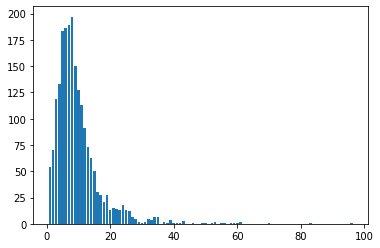

In [86]:
plt.bar(list(word_length_count.keys()), list(word_length_count.values()))


In [87]:
word_length_count

defaultdict(int,
            {1: 54,
             2: 70,
             3: 119,
             4: 133,
             5: 183,
             6: 186,
             7: 189,
             8: 197,
             9: 150,
             10: 127,
             13: 73,
             11: 113,
             12: 91,
             17: 27,
             16: 30,
             14: 63,
             27: 6,
             15: 50,
             24: 18,
             25: 13,
             18: 21,
             23: 13,
             19: 27,
             21: 15,
             35: 6,
             22: 14,
             33: 4,
             20: 13,
             26: 12,
             32: 5,
             39: 4,
             42: 1,
             56: 1,
             28: 5,
             34: 6,
             38: 1,
             43: 3,
             46: 1,
             41: 1,
             37: 2,
             29: 2,
             59: 1,
             49: 1,
             31: 2,
             52: 1,
             58: 1,
             61: 2,
             30: 

In [88]:
sub_csv = pd.DataFrame(list(vocab_index2units2freq.items()),
                      columns=['index','frequency'])
sub_csv.reset_index(level=0, inplace=True)
sub_csv.to_csv('subword_units_map_drug_bank_freq_100.csv')

In [89]:
(sub_csv['index'].values)

array(['G', 'i', 'l', ..., '(CC1CCCCC1)', '(CCC)', '#N)'], dtype=object)